In [126]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem
from scipy.ndimage import uniform_filter1d  # For smoothing

base_dir = "results/Curriculum-Learning/MiniGrid/"
# Define the base directory and experiment names
dir_env1 = "PickupKey-v0"
dir_env2 = "Unlock-v0"
dir_env3 = "UnlockPickup-v0"
dir_env4 = "BlockedUnlockPickup-v0"

curriculum_dirs = [dir_env1, dir_env2, dir_env3, dir_env4]

# COMP EXP: "PPO_AE_Offline_NO_Freeze", "PPO_AE_Offline_CNN_Freeze", "PPO_IMDP_Offline_CNN_Part_Freeze", "PPO_IMDP_Offline_Freeze", "PPO_AEGIS_ALT1_1E", "PPO_AEGIS_5E6", "PPO_AEGIS_TCL"

# OFFLINE
# DATA EXP: "PPO_LMDP_Offline", "PPO_LMDP_Offline", "PPO_LMDP_Offline_5E6", "PPO_LMDP_Offline_25e5", "PPO_LMDP_Offline_10e5", "PPO_LMDP_Offline_5E5", "PPO_LMDP_Offline_5E4", "PPO_LMDP_Offline_5E3"
# EPOCHS EXP: "PPO_LMDP_Offline_5E5_10", "PPO_LMDP_Offline_5E5_20", "PPO_LMDP_Offline_5E5_50", "PPO_LMDP_Offline_5E5_100", "PPO_LMDP_Offline_5E5_200"

# BUFFER EXP: "PPO_AEGIS_Buffer_64", "PPO_AEGIS_Buffer_128", "PPO_AEGIS_Buffer_256", "PPO_AEGIS_Buffer_512", "PPO_AEGIS_Buffer_1024", "PPO_AEGIS_ALT1_1E", "PPO_AEGIS_5E6", "PPO_AEGIS_TCL" 
# "PPO_LMDP_Offline_5E5",  "PPO_AEGIS_ALT1_1E", "PPO_AEGIS_5E6", "PPO_AEGIS_TCL",
experiments =  ["PPO_Vanilla"
                ]
titles = ["Curriculum Vanilla PPO"]
# Define the number of seeds
num_seeds = 10

# Initialize dictionaries to store data
episode_rewards = {task: {exp: [] for exp in experiments} for task in curriculum_dirs}
episode_lengths = {task: {exp: [] for exp in experiments} for task in curriculum_dirs}
steps = {task: {exp: [] for exp in experiments} for task in curriculum_dirs}  # To store step numbers

# Read data from CSV files
for task in curriculum_dirs:
    for exp in experiments:
        for seed in range(1, num_seeds + 1):
            file_path = os.path.join(base_dir+task, exp, f"seed-{seed}", "train.csv")
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                episode_rewards[task][exp].append(df['true_episode_reward'])
                episode_lengths[task][exp].append(df['episode_length'])
                steps[task][exp].append(df['step'].values)  # Read step numbers
            else:
                print(f"File not found: {file_path}")

# Align data to the length of the longest seed for each experiment
def align_data(data):
    max_length = max(len(seed_data) for seed_data in data)
    aligned_data = []
    for seed_data in data:
        if len(seed_data) < max_length:
            # Repeat the last value to match the length of the longest seed
            aligned_data.append(np.pad(seed_data, (0, max_length - len(seed_data)), mode='edge'))
        else:
            aligned_data.append(seed_data)
    return np.array(aligned_data)

aligned_episode_rewards = {task: {exp: align_data(episode_rewards[task][exp]) for exp in experiments} for task in curriculum_dirs}
aligned_episode_lengths = {task: {exp: align_data(episode_lengths[task][exp]) for exp in experiments} for task in curriculum_dirs}
aligned_steps = {task: {exp: align_data(steps[task][exp]) for exp in experiments} for task in curriculum_dirs}

# Compute mean and standard error for each experiment
def compute_stats(data):
    mean = np.mean(data, axis=0)
    std_error = sem(data, axis=0)
    return mean, std_error

episode_rewards_stats = {task: {exp: compute_stats(aligned_episode_rewards[task][exp]) for exp in experiments} for task in curriculum_dirs}
episode_lengths_stats = {task: {exp: compute_stats(aligned_episode_lengths[task][exp]) for exp in experiments} for task in curriculum_dirs}
steps_stats = {task: {exp: compute_stats(aligned_steps[task][exp]) for exp in experiments} for task in curriculum_dirs}

# Smoothing function using a moving average
def smooth_data(data, window_size=10):
    """Apply a moving average to smooth the data."""
    return uniform_filter1d(data, size=window_size, mode='nearest')

# Function to find the closest index in a sorted array using numpy
def find_closest_index_np(sorted_array, x):
    sorted_array = np.asarray(sorted_array)
    idx = np.searchsorted(sorted_array, x, side="left")
    
    if idx > 0 and (idx == len(sorted_array) or 
                    np.abs(x - sorted_array[idx-1]) <= np.abs(x - sorted_array[idx])):
        return idx - 1
    else:
        return idx

In [127]:
single_task_base_dir = "results/Single_Task/MiniGrid/"
single_tasks = [dir_env2, dir_env3, dir_env4]
single_task_experiments =  ["PPO_Vanilla"
                ]
single_task_titles = ["PPO Unlock Single Task",
                      "PPO UnlockPickup Single Task",
                      "PPO BlockedUnlockPickup Single Task"]

# Initialize dictionaries to store data
st_episode_rewards = {task: {exp: [] for exp in single_task_experiments} for task in single_tasks}
st_episode_lengths = {task: {exp: [] for exp in single_task_experiments} for task in single_tasks}
st_steps = {task: {exp: [] for exp in single_task_experiments} for task in single_tasks}  # To store step numbers

# Read data from CSV files
for task in single_tasks:
    for exp in single_task_experiments:
        for seed in range(1, num_seeds + 1):
            file_path = os.path.join(single_task_base_dir+task, exp, f"seed-{seed}", "train.csv")
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                st_episode_rewards[task][exp].append(df['true_episode_reward'])
                st_episode_lengths[task][exp].append(df['episode_length'])
                st_steps[task][exp].append(df['step'].values)  # Read step numbers
            else:
                print(f"File not found: {file_path}")

st_aligned_episode_rewards = {task: {exp: align_data(st_episode_rewards[task][exp]) for exp in single_task_experiments} for task in single_tasks}
st_aligned_episode_lengths = {task: {exp: align_data(st_episode_lengths[task][exp]) for exp in single_task_experiments} for task in single_tasks}
st_aligned_steps = {task: {exp: align_data(st_steps[task][exp]) for exp in single_task_experiments} for task in single_tasks}

st_episode_rewards_stats = {task: {exp: compute_stats(st_aligned_episode_rewards[task][exp]) for exp in single_task_experiments} for task in single_tasks}
st_episode_lengths_stats = {task: {exp: compute_stats(st_aligned_episode_lengths[task][exp]) for exp in single_task_experiments} for task in single_tasks}
st_steps_stats = {task: {exp: compute_stats(st_aligned_steps[task][exp]) for exp in single_task_experiments} for task in single_tasks}


In [129]:
# Plotting function
def plot_results(stats, steps_stats, ylabel, title, filename, window_size=10):
    plt.figure(figsize=(12, 6))

    # Create a color map for experiments
    experiment_colors = {exp: f'C{i}' for i, exp in enumerate(experiments)}

    cmap = plt.cm.Greens
    # Initialize a variable to keep track of the cumulative step offset
    cumulative_steps = 0
    x_position = 500000  # Starting x position for first task label
    
    for i, task in enumerate(curriculum_dirs):
        for j, exp in enumerate(experiments):
            mean, std_error = stats[task][exp]
            step_mean, _ = steps_stats[task][exp]  # Use step numbers for the x-axis

            # Smooth the mean and std_error
            smoothed_mean = smooth_data(mean, window_size)
            smoothed_std_error = smooth_data(std_error, window_size)

            k100 = find_closest_index_np(step_mean, 100000)
            k50 = find_closest_index_np(step_mean, 50000)

            # Shift the steps by the cumulative offset
            shifted_steps = step_mean + cumulative_steps

            # Use the same color for this experiment across all tasks
            color = experiment_colors[exp]

            print(f'{exp}_{task}: at {step_mean[k50]}: {smoothed_mean[k50]}, at {step_mean[k100]}: {smoothed_mean[k100]}, max:{max(smoothed_mean)}')
            
            plt.plot(shifted_steps, smoothed_mean, label=f'{titles[j]}', color=color)
            plt.fill_between(shifted_steps, smoothed_mean - smoothed_std_error, smoothed_mean + smoothed_std_error, alpha=0.2, color=color)

            if experiments:  # Check if experiments list is not empty
                last_exp_steps, _ = steps_stats[task][experiments[-1]]
                cumulative_steps += last_exp_steps[-1]  # Add the last step of the last experiment
        # Add task label at specified x position
        plt.text(x_position, plt.ylim()[1] * 0.97,  # 97% up the y-axis
                task,
                ha='center', va='top',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
        # Calculate color from colormap (progressively darker)
        bg_color = cmap(0.0 + 1.0 * i/len(curriculum_dirs))  # Adjust 0.3 and 0.5 to control gradient

        plt.axvspan(x_position - 500000, x_position + 500000, 
                   facecolor=bg_color, alpha=0.5, zorder=-1)
        # Update x position for next label (+1000 from current)
        x_position += last_exp_steps[-1]
    
    plt.xlabel('Step')
    plt.ylabel(ylabel)
    plt.title(title)
    # Adjust legend to show only experiment names once
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = []
    unique_handles = []
    for handle, label in zip(handles, labels):
        if label not in unique_labels and label is not None:
            unique_labels.append(label)
            unique_handles.append(handle)
    plt.legend(unique_handles, unique_labels, loc='center right')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename+".png")
    plt.show()

In [131]:
# Plotting function
def plot_comparative_results(stats, steps_stats, ylabel, title, filename, window_size=10):
    plt.figure(figsize=(12, 6))

    # Create a color map for experiments
    experiment_colors = {exp: f'C{i+len(single_tasks)}' for i, exp in enumerate(experiments)}
    # Initialize storage for concatenated data (per experiment)
    exp_data = {exp: {'steps': [], 'mean': [], 'std_error': []} for exp in experiments}

    cmap = plt.cm.Greens
    # Initialize a variable to keep track of the cumulative step offset
    cumulative_steps = 0
    x_position = 500000  # Starting x position for first task label

    for i, task in enumerate(single_tasks):
        for j, exp in enumerate(single_task_experiments):
            mean, std_error = st_episode_rewards_stats[task][exp]
            step_mean, _ = st_steps_stats[task][exp]  # Use step numbers for the x-axis

            # Smooth the mean and std_error
            smoothed_mean = smooth_data(mean, window_size)
            smoothed_std_error = smooth_data(std_error, window_size)

            k100 = find_closest_index_np(step_mean, 100000)
            k50 = find_closest_index_np(step_mean, 50000)
            
            # Use the same color for this experiment across all tasks
            color = experiment_colors[exp]

            print(f'{exp}_{task}: at {step_mean[k50]}: {smoothed_mean[k50]}, at {step_mean[k100]}: {smoothed_mean[k100]}, max:{max(smoothed_mean)}')
            
            plt.plot(step_mean, smoothed_mean, label=f'{single_task_titles[i]}')
            plt.fill_between(step_mean, smoothed_mean - smoothed_std_error, smoothed_mean + smoothed_std_error, alpha=0.2)

    for j, exp in enumerate(experiments):
        for i, task in enumerate(curriculum_dirs):
            mean, std_error = stats[task][exp]
            step_mean, _ = steps_stats[task][exp]  # Use step numbers for the x-axis

            # Smooth the mean and std_error
            smoothed_mean = smooth_data(mean, window_size)
            smoothed_std_error = smooth_data(std_error, window_size)

            k100 = find_closest_index_np(step_mean, 100000)
            k50 = find_closest_index_np(step_mean, 50000)

            # Shift the steps by the cumulative offset
            shifted_steps = step_mean + cumulative_steps

            # Store concatenated data
            exp_data[exp]['steps'].extend(shifted_steps)
            exp_data[exp]['mean'].extend(smoothed_mean)
            exp_data[exp]['std_error'].extend(smoothed_std_error)

            if experiments:  # Check if experiments list is not empty
                last_exp_steps, _ = steps_stats[task][experiments[-1]]
                cumulative_steps += last_exp_steps[-1]  # Add the last step of the last experiment

    for j, exp in enumerate(experiments):
        steps = np.array(exp_data[exp]['steps'])
        mean = np.array(exp_data[exp]['mean'])
        std_error = np.array(exp_data[exp]['std_error'])

        # Use the same color for this experiment across all tasks
        color = experiment_colors[exp]

        print(f'{exp}_{task}: at {step_mean[k50]}: {smoothed_mean[k50]}, at {step_mean[k100]}: {smoothed_mean[k100]}, max:{max(smoothed_mean)}')
        
        plt.plot(steps, mean, label=f'{titles[j]}', color=color)
        plt.fill_between(steps, mean - std_error, mean + std_error, alpha=0.2, color=color)

    for i, task in enumerate(curriculum_dirs):
        # Add task label at specified x position
        plt.text(x_position, plt.ylim()[1] * 0.97,  # 97% up the y-axis
                task,
                ha='center', va='top',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
        # Calculate color from colormap (progressively darker)
        bg_color = cmap(0.0 + 1.0 * i/len(curriculum_dirs))  # Adjust 0.3 and 0.5 to control gradient

        plt.axvspan(x_position - 500000, x_position + 500000, 
                   facecolor=bg_color, alpha=0.5, zorder=-1)
        # Update x position for next label (+1000 from current)
        x_position += last_exp_steps[-1]
    
    plt.xlabel('Step')
    plt.ylabel(ylabel)
    plt.title(title)
    # Adjust legend to show only experiment names once
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = []
    unique_handles = []
    for handle, label in zip(handles, labels):
        if label not in unique_labels and label is not None:
            unique_labels.append(label)
            unique_handles.append(handle)
    plt.legend(unique_handles, unique_labels, loc='center right')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename+".png")
    plt.show()

PPO_Vanilla_Unlock-v0: at 49977.4: 0.30816699999999997, at 100054.2: 0.3700410000000005, max:0.4490899999999995
PPO_Vanilla_UnlockPickup-v0: at 49919.9: 0.11344500000000002, at 99981.6: 0.15076600000000004, max:0.32852100000000034
PPO_Vanilla_BlockedUnlockPickup-v0: at 49997.2: 0.0, at 99992.7: 0.0, max:0.004314
PPO_Vanilla_BlockedUnlockPickup-v0: at 50000.0: 0.0004339999999999998, at 99997.4: 0.0, max:0.005127999999999998


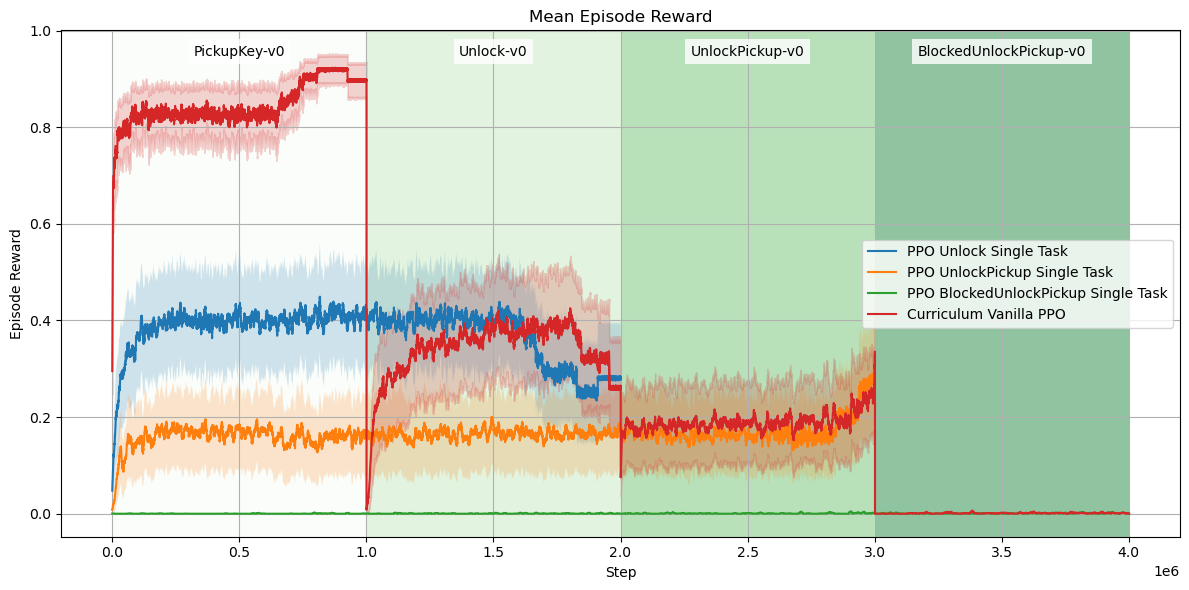

In [132]:
# Plot episode rewards
plot_comparative_results(episode_rewards_stats, steps_stats, 
             'Episode Reward', 'Mean Episode Reward', 
             filename="plot_episode_reward", window_size=50)

PPO_Vanilla_PickupKey-v0: at 50006.6: 0.8099259999999995, at 99981.7: 0.8271789999999974, max:0.9231939999999983
PPO_Vanilla_Unlock-v0: at 49956.3: 0.2460250000000001, at 99999.9: 0.2702429999999998, max:0.4254759999999998
PPO_Vanilla_UnlockPickup-v0: at 49975.7: 0.1767880000000002, at 100024.0: 0.15927800000000022, max:0.3355430000000017
PPO_Vanilla_BlockedUnlockPickup-v0: at 50000.0: 0.0004339999999999998, at 99997.4: 0.0, max:0.005127999999999998


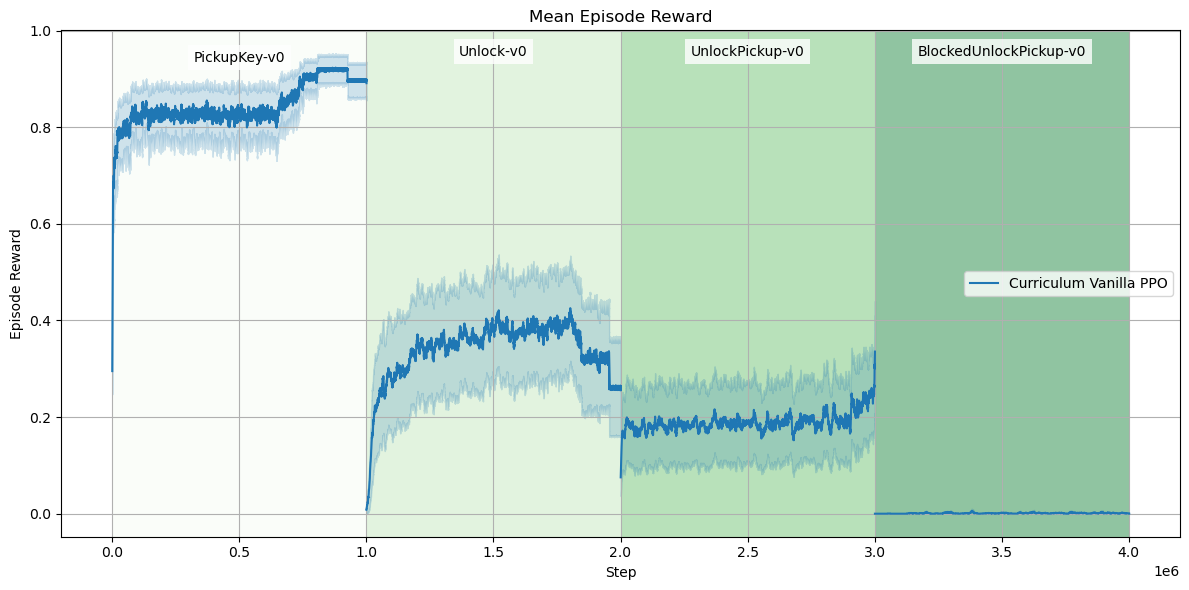

In [133]:
# Plot episode rewards
plot_results(episode_rewards_stats, steps_stats, 
             'Episode Reward', 'Mean Episode Reward', 
             filename="plot_episode_reward", window_size=50)

PPO_VanillaGPU: at 52580.3: 43.724, at 100k: 33.200000000000095, max:99.17200000000004
PPO_LMDP_Offline_5E6: at 49919.4: 40.489999999999895, at 100k: 22.302000000000092, max:99.76799999999999
PPO_LMDP_Offline_25e5: at 45215.1: 56.03400000000011, at 100k: 23.78800000000017, max:99.75599999999999
PPO_LMDP_Offline_10e5: at 50024.2: 33.31800000000001, at 100k: 25.308000000000135, max:99.62400000000001
PPO_LMDP_Offline_5E5: at 39637.2: 18.936000000000053, at 100k: 14.799999999999994, max:99.38600000000001
PPO_LMDP_Offline_5E4: at 46652.5: 28.18399999999996, at 100k: 21.100000000000012, max:99.54799999999999
PPO_LMDP_Offline_5E3: at 51313.0: 26.72799999999998, at 100k: 18.227999999999962, max:99.53599999999999


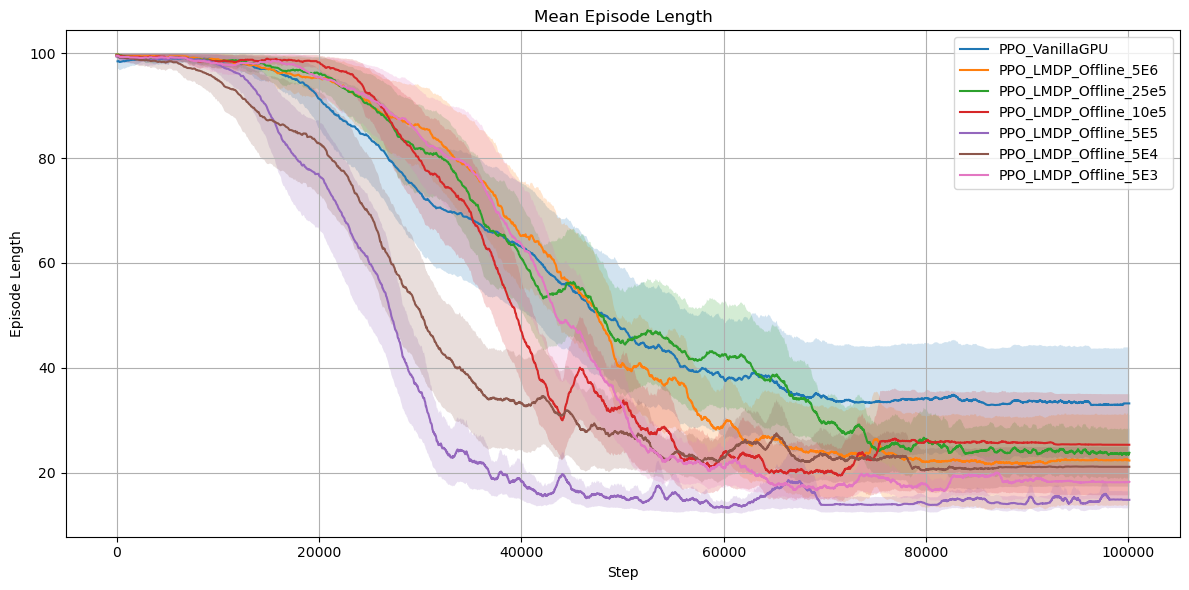

In [3]:
# Plot episode lengths
plot_results(episode_lengths_stats, steps_stats, 
             'Episode Length', 'Mean Episode Length', 
             filename="plot_episode_length", window_size=50)